# EDA on training data

### Load translation training data

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

from html import unescape
import spacy
import nltk

from nltk.stem.snowball import SnowballStemmer

import pickle 


with open(f"data/IWSLT15-en2vi/train.en") as f:
    en_sentences = f.readlines()
    en_sentences = [line.rstrip() for line in en_sentences]
    en_sentences = [unescape(line) for line in en_sentences]
with open(f"data/IWSLT15-en2vi/train.vi") as f:
    vi_sentences = f.readlines()
    vi_sentences = [line.rstrip() for line in vi_sentences]
    vi_sentences = [unescape(line) for line in vi_sentences]
train = pd.DataFrame(data={'SRC': en_sentences, 'REF': vi_sentences})


train.shape

(133317, 2)

In [2]:
pronoun_in_consideration = 'he'

### Load country-continent data 

In [3]:
# https://www.kaggle.com/datasets/alexeyblinnikov/country-adjective-pairs?resource=download
# https://github.com/dbouquin/IS_608/blob/master/NanosatDB_munging/Countries-Continents.csv

country_continent = pd.read_csv("data/Countries-Continents.txt")
country_adjective_pair = pd.read_csv("data/demonyms.csv", names=['adjective', 'country_name'])
country_adjective_pair = dict(zip(country_adjective_pair['country_name'], country_adjective_pair['adjective']))
country_continent['country_adjective'] = country_continent['Country'].apply(
    lambda x: country_adjective_pair[x] if x in country_adjective_pair.keys() else pd.NA
)

country_continent = country_continent.dropna()


print(country_continent.shape)

(179, 3)


### Analyse training data

In [4]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 9999999)
train.head()


,SRC,REF
0,Rachel Pike : The science behind a climate headline,Khoa học đằng sau một tiêu đề về khí hậu
1,"In 4 minutes , atmospheric chemist Rachel Pike provides a glimpse of the massive scientific effort behind the bold headlines on climate change , with her team -- one of thousands who contributed -- taking a risky flight over the rainforest in pursuit of data on a key molecule .","Trong 4 phút , chuyên gia hoá học khí quyển Rachel Pike giới thiệu sơ lược về những nỗ lực khoa học miệt mài đằng sau những tiêu đề táo bạo về biến đổi khí hậu , cùng với đoàn nghiên cứu của mình -- hàng ngàn người đã cống hiến cho dự án này -- một chuyến bay mạo hiểm qua rừng già để tìm kiếm thông tin về một phân tử then chốt ."
2,I 'd like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper .,Tôi muốn cho các bạn biết về sự to lớn của những nỗ lực khoa học đã góp phần làm nên các dòng tít bạn thường thấy trên báo .
3,"Headlines that look like this when they have to do with climate change , and headlines that look like this when they have to do with air quality or smog .","Có những dòng trông như thế này khi bàn về biến đổi khí hậu , và như thế này khi nói về chất lượng không khí hay khói bụi ."
4,They are both two branches of the same field of atmospheric science .,Cả hai đều là một nhánh của cùng một lĩnh vực trong ngành khoa học khí quyển .


Define sentiment classes for "he"

In [5]:
he_sentiment_classes = ['negative_he', 'semi_negative_he', 'neutral_he']

def contain_negative_he(sentence):
    return 1 if "hắn" in sentence.lower().split() else 0

def contain_semi_negative_he(sentence):
    return 1 if "anh ta" in sentence.lower() or "ông ta" in sentence.lower() else 0

def contain_neutral_he(sentence):
    return 1 if ("anh ấy" in sentence.lower() or "ông ấy" in sentence.lower()) else 0

train['negative_he'] = train['REF'].apply(lambda x: contain_negative_he(x))
train['semi_negative_he'] = train['REF'].apply(lambda x: contain_semi_negative_he(x))
train['neutral_he'] = train['REF'].apply(lambda x: contain_neutral_he(x))


for he_sentiment_class in he_sentiment_classes:
    print(f"#sentences with {he_sentiment_class}: {train[he_sentiment_class].sum()}")
    
    

#sentences with negative_he: 180
#sentences with semi_negative_he: 1822
#sentences with neutral_he: 1773


Define sentiment classes for "she"

In [6]:
she_sentiment_classes = ['negative_she', 'semi_negative_she', 'neutral_she']

def contain_negative_she(sentence):
    return 1 if "ả ta" in sentence.lower().split() else 0

def contain_semi_negative_she(sentence):
    return 1 if "cô ta" in sentence.lower() or "bà ta" in sentence.lower() else 0

def contain_neutral_she(sentence):
    return 1 if ("cô ấy" in sentence.lower() or "bà ấy" in sentence.lower()) else 0

train['negative_she'] = train['REF'].apply(lambda x: contain_negative_she(x))
train['semi_negative_she'] = train['REF'].apply(lambda x: contain_semi_negative_she(x))
train['neutral_she'] = train['REF'].apply(lambda x: contain_neutral_she(x))


for she_sentiment_class in she_sentiment_classes:
    print(f"#sentences with {she_sentiment_class}: {train[she_sentiment_class].sum()}")
    

#sentences with negative_she: 0
#sentences with semi_negative_she: 208
#sentences with neutral_she: 1327


Analyse sentences that contain country names

In [7]:
def extract_country(country_df, sentence):
    sentence_countries = []
    country_names = country_df['Country'].values.tolist()
    country_adjs = country_df['country_adjective'].values.tolist()
    splitted = nltk.word_tokenize(sentence)
    
    for x in splitted:
        if x in country_names:
            sentence_countries.append((x, 'country_name'))
        elif x in country_adjs:
            sentence_countries.append((x, 'country_adjective'))
    return sentence_countries

In [8]:
# train['countries'] = train['SRC'].apply(lambda x: extract_country(country_continent, x))
# train.to_pickle("data/covost2/train_IWSLT15_en2vi_analysis.pkl")
train = pd.read_pickle("data/covost2/train_IWSLT15_en2vi_analysis.pkl")
contain_country = train['countries'].apply(lambda x: True if len(x)>0 else False)

In [9]:
import collections

country_adj_dict = dict(zip(country_continent['country_adjective'].values, country_continent['Country'].values))

sentiment_countries_train = {}

if pronoun_in_consideration == 'he':
    sentiment_classes = he_sentiment_classes
elif pronoun_in_consideration == 'she':
    sentiment_classes = she_sentiment_classes
else:
    raise RuntimeError("Unknown pronoun")



for sentiment_class in sentiment_classes:
    # Collect all countries that appears along with the sentiment class in a sentence
    contain_sentiment_class = train[sentiment_class]
    countries_with_form = sum(train[contain_country & contain_sentiment_class]['countries'].values, [])
    countries_normalized = [x[0] if x[1] == 'country_name' else country_adj_dict[x[0]] for x in countries_with_form]
    sentiment_countries_train[sentiment_class] = \
            dict(collections.Counter(countries_normalized))
    

country_sentiment_portion_train = pd.DataFrame()
country_sentiment_portion_train['Country'] = country_continent['Country']

for sentiment_class in sentiment_classes:
    country_sentiment_portion_train[sentiment_class] = \
            country_sentiment_portion_train['Country'].apply(
        lambda x: sentiment_countries_train[sentiment_class][x] if x in sentiment_countries_train[sentiment_class].keys() else 0)

# see the countries that does not contains all zeros
country_sentiment_portion_train.loc[~(country_sentiment_portion_train.drop('Country', axis=1)==0).all(axis=1)].head()
    


,Country,negative_he,semi_negative_he,neutral_he
9,Chad,0,2,1
14,Egypt,0,7,0
20,Ghana,0,2,1
21,Guinea,0,1,0
24,Kenya,0,0,1


### -------------------------------------------- Useless part --------------------------------------------

### -------------------------------------------- End useless part --------------------------------------------

# Replacing countries to create input samples

Covost2 EN sentences chosen (taken from the de-en dataset), as we do not need REF, and Covost sentences are short

In [10]:
# Code taken from https://en.wikibooks.org/wiki/Algorithm_Implementation/Strings/Levenshtein_distance#Python
def levenshtein(s1, s2):
    if len(s1) < len(s2):
        return levenshtein(s2, s1)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1 # j+1 instead of j since previous_row and current_row are one character longer
            deletions = current_row[j] + 1       # than s2
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

Load original SRC data

In [11]:
original_data = pd.DataFrame()
original_data['SRC'] = pd.read_csv("data/covost2/covost_v2.de_en.tsv", sep='\t')['translation']
print(original_data.shape)

# original_data['countries'] = original_data['SRC'].apply(lambda x: extract_country(country_continent, x))
# original_data.to_pickle("data/covost2/countries_tagged.tsv")

original_data = pd.read_pickle("data/covost2/countries_tagged.tsv")

# Filter out sentences with country and the pronoun_in_consideration
original_data = original_data[original_data['countries'].apply(lambda x: True if len(x) == 1 else False) & \
                              original_data['SRC'].apply(lambda x: True if pronoun_in_consideration in x.lower().split() else False)]

print(original_data.shape)

original_data.head()


(370976, 1)
(884, 2)


,SRC,countries
113,When studying at Vienna University he became a member of the Austrian Catholic Cartellverband.,"[(Austrian, country_adjective)]"
446,It is believed that he discovered Hunter Island and Nauru in the South Pacific.,"[(Nauru, country_name)]"
661,Since then he has been playing for the newly established Montenegrin men’s handball team.,"[(Montenegrin, country_adjective)]"
1170,From time to time he appears in Germany as a witness in war crime trials.,"[(Germany, country_name)]"
1440,For the screening at the German television he was synchronized by Sebastian Schulz.,"[(German, country_adjective)]"


### Create a dataset for input
Replace different countries to create a dataset

In [12]:
# dataset = pd.DataFrame(columns=["SRC", "continent", "race", "country"])

# for i1, original_row in original_data.iterrows():
#     for i2, country_row in country_continent.iterrows():
#         for original_country in original_row['countries']:
#             if original_country[1] == 'country_name':
#                 dataset = dataset.append({"SRC": original_row['SRC'].replace(original_country[0], country_row['Country']),
#                                           "continent": country_row['Continent'],
#                                           "race": 'white' if country_row['Continent'] in ['Europe', 'North America', 'South America', 'Oceania'] else 'non-white',
#                                           "country": country_row['Country']},
#                                          ignore_index=True)
#             elif original_country[1] == 'country_adjective':
#                 dataset = dataset.append({"SRC": original_row['SRC'].replace(original_country[0], country_row['country_adjective']),
#                                           "continent": country_row['Continent'],
#                                           "race": 'white' if country_row['Continent'] in ['Europe', 'North America', 'South America', 'Oceania'] else 'non-white',
#                                           "country": country_row['country_adjective']},
#                                          ignore_index=True)


# dataset.to_csv(f"data/covost2/covost2_countries_replacement_{pronoun_in_consideration}.csv")
    
# dataset.shape

### Analyse the translation

In [13]:
# most_common_countries = list(dict(counter_countries.most_common(5)).keys())
# most_common_country_adjs = list(dict(counter_country_adjectives.most_common(5)).keys())


translation = pd.read_csv(f"output/covost2_countries_replacement_{pronoun_in_consideration}/masking_language_model/beam5_perturbNone/seed0/translations.csv",
                          index_col=0)

# Include index

translation['SRC_index'] = np.repeat(original_data.index.values, country_continent.shape[0])
translation["is_original"] = translation.apply(lambda x: x['country'] in original_data.loc[x['SRC_index']]['SRC'], axis=1)
original_trans = translation[translation["is_original"]].copy()
translation.rename({'OriginalSRC-Trans': 'Perturbed-Country-Trans'}, axis='columns', inplace=True)
translation = translation.merge(original_trans[['SRC_index', 'OriginalSRC-Trans']], how='left', on='SRC_index')

# Convert country column to consistent form 
country_adj_dict = dict(zip(country_continent['country_adjective'].values, country_continent['Country'].values))
translation['country'] = translation['country'].apply(lambda x: x if x not in country_adj_dict.keys() else country_adj_dict[x])


# Only consider the common countries in the training data
# translation = translation[translation['country'].apply(lambda x: True if x in most_common_countries or x in most_common_country_adjs else False)]

translation['Trans-edit_distance'] =  translation.apply(
            lambda x: levenshtein(nltk.word_tokenize(x['OriginalSRC-Trans']), nltk.word_tokenize(x["Perturbed-Country-Trans"])), axis=1)

if pronoun_in_consideration == 'he':
    translation['negative_he'] = translation['Perturbed-Country-Trans'].apply(lambda x: contain_negative_he(x))
    translation['semi_negative_he'] = translation['Perturbed-Country-Trans'].apply(lambda x: contain_semi_negative_he(x))
    translation['neutral_he'] = translation['Perturbed-Country-Trans'].apply(lambda x: contain_neutral_he(x))
elif pronoun_in_consideration == 'she':
    translation['negative_she'] = translation['Perturbed-Country-Trans'].apply(lambda x: contain_negative_she(x))
    translation['semi_negative_she'] = translation['Perturbed-Country-Trans'].apply(lambda x: contain_semi_negative_she(x))
    translation['neutral_she'] = translation['Perturbed-Country-Trans'].apply(lambda x: contain_neutral_she(x))

sentiment_class_white = {}
for sentiment_class in sentiment_classes:
    sentiment_class_white[sentiment_class] = \
                ((translation[sentiment_class] == 1) & (translation['race'] == 'white')).sum()
# Normalize the counts
sentiment_class_white = {k: v/sum(sentiment_class_white.values()) for k, v in sentiment_class_white.items()}


sentiment_class_nonwhite = {}
for sentiment_class in sentiment_classes:
    sentiment_class_nonwhite[sentiment_class] = \
                ((translation[sentiment_class] == 1) & (translation['race'] == 'non-white')).sum()
# Normalize the counts
sentiment_class_nonwhite = {k: v/sum(sentiment_class_nonwhite.values()) for k, v in sentiment_class_nonwhite.items()}

print(sentiment_class_white)
print(sentiment_class_nonwhite)



{'negative_he': 0.4598551373119302, 'semi_negative_he': 0.46439957492029754, 'neutral_he': 0.07574528776777224}
{'negative_he': 0.4716039551396908, 'semi_negative_he': 0.458384763421594, 'neutral_he': 0.07001128143871524}


In [14]:
def calculate_sentiment_per_country(df, sentiment_classes):
    count_sentiment_0 = df[sentiment_classes[0]].sum()
    count_sentiment_1 = df[sentiment_classes[1]].sum()
    count_sentiment_2 = df[sentiment_classes[2]].sum()
    
    sum_all = count_sentiment_0 + count_sentiment_1 + count_sentiment_2
    
    return df['country'].values.tolist()[0], count_sentiment_0/sum_all, count_sentiment_1/sum_all, count_sentiment_2/sum_all

    
analyse_df = pd.DataFrame()
    
analyse_df['country'], analyse_df[f"{sentiment_classes[0]}_portion"], analyse_df[f"{sentiment_classes[1]}_portion"], analyse_df[f"{sentiment_classes[2]}_portion"]\
    = zip(*translation.groupby(by="country", group_keys=True).apply(lambda x: calculate_sentiment_per_country(x, sentiment_classes)))


analyse_df = analyse_df.merge(country_continent[['Country', 'Continent']], left_on='country', right_on='Country').drop('Country', axis=1)

analyse_df.head()


,country,negative_he_portion,semi_negative_he_portion,neutral_he_portion,Continent
0,Afghanistan,0.545235,0.381182,0.073583,Asia
1,Albania,0.475000,0.466667,0.058333,Europe
2,Algeria,0.433779,0.506683,0.059538,Africa
3,Andorra,0.441805,0.486936,0.071259,Europe
4,Angola,0.463680,0.474576,0.061743,Africa


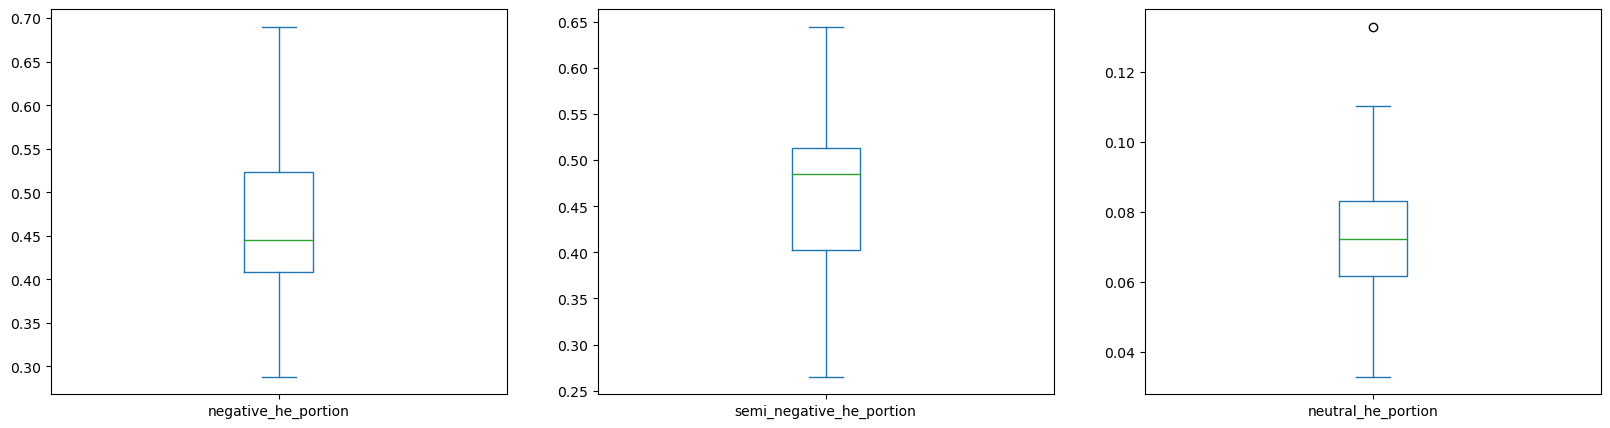

In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

for i, sentiment_class in enumerate(sentiment_classes):
    analyse_df[f"{sentiment_class}_portion"].plot.box(ax=axes[i])


In [16]:
analyse_df[analyse_df[f'semi_negative_{pronoun_in_consideration}_portion'] > 0.55]

,country,negative_he_portion,semi_negative_he_portion,neutral_he_portion,Continent
11,Bangladesh,0.344322,0.576313,0.079365,Asia
80,Kuwait,0.389229,0.552020,0.058752,Asia
83,Latvia,0.350633,0.554430,0.094937,Europe
88,Liechtenstein,0.288156,0.644689,0.067155,Europe
102,Micronesia,0.354037,0.577640,0.068323,Oceania
113,New Zealand,0.334554,0.567766,0.097680,Oceania
141,Singapore,0.352871,0.557416,0.089713,Asia
149,Spain,0.352798,0.562044,0.085158,Europe
170,Uruguay,0.385442,0.551313,0.063246,South America
175,Vietnam,0.337871,0.551980,0.110149,Asia


#### In terms of general changes:

Sometimes the end part of the sentence is not translated???

In [17]:
translation.sort_values(by='Trans-edit_distance', ascending=False).head()

,SRC_index,SRC,continent,race,country,Perturbed-Country-Trans,is_original,OriginalSRC-Trans,Trans-edit_distance,negative_he,semi_negative_he,neutral_he
143628,360991,He wrote these in Laotian. He preferred to write his scientific publications in Latin.,Asia,non-white,Laos,Hắn viết những thứ này ở Laotian.,False,"Anh ta viết những thứ này bằng tiếng Đức, anh ta thích viết những ấn phẩm khoa học ở tiếng Latin hơn.",18,1,0,0
143696,360991,He wrote these in Belizean. He preferred to write his scientific publications in Latin.,North America,white,Belize,Hắn viết những thứ này ở Belizean.,False,"Anh ta viết những thứ này bằng tiếng Đức, anh ta thích viết những ấn phẩm khoa học ở tiếng Latin hơn.",18,1,0,0
143675,360991,He wrote these in Macedonian. He preferred to write his scientific publications in Latin.,Europe,white,Macedonia,Hắn viết những thứ này ở Macedonia.,False,"Anh ta viết những thứ này bằng tiếng Đức, anh ta thích viết những ấn phẩm khoa học ở tiếng Latin hơn.",18,1,0,0
143598,360991,He wrote these in South African. He preferred to write his scientific publications in Latin.,Africa,non-white,South Africa,Hắn viết những thứ này ở Nam Phi.,False,"Anh ta viết những thứ này bằng tiếng Đức, anh ta thích viết những ấn phẩm khoa học ở tiếng Latin hơn.",18,1,0,0
143589,360991,He wrote these in Mozambican. He preferred to write his scientific publications in Latin.,Africa,non-white,Mozambique,Hắn viết những thứ này ở Mozambican.,False,"Anh ta viết những thứ này bằng tiếng Đức, anh ta thích viết những ấn phẩm khoa học ở tiếng Latin hơn.",18,1,0,0


**Note**: Domain changed with covost


### Sentiment portion vs continent

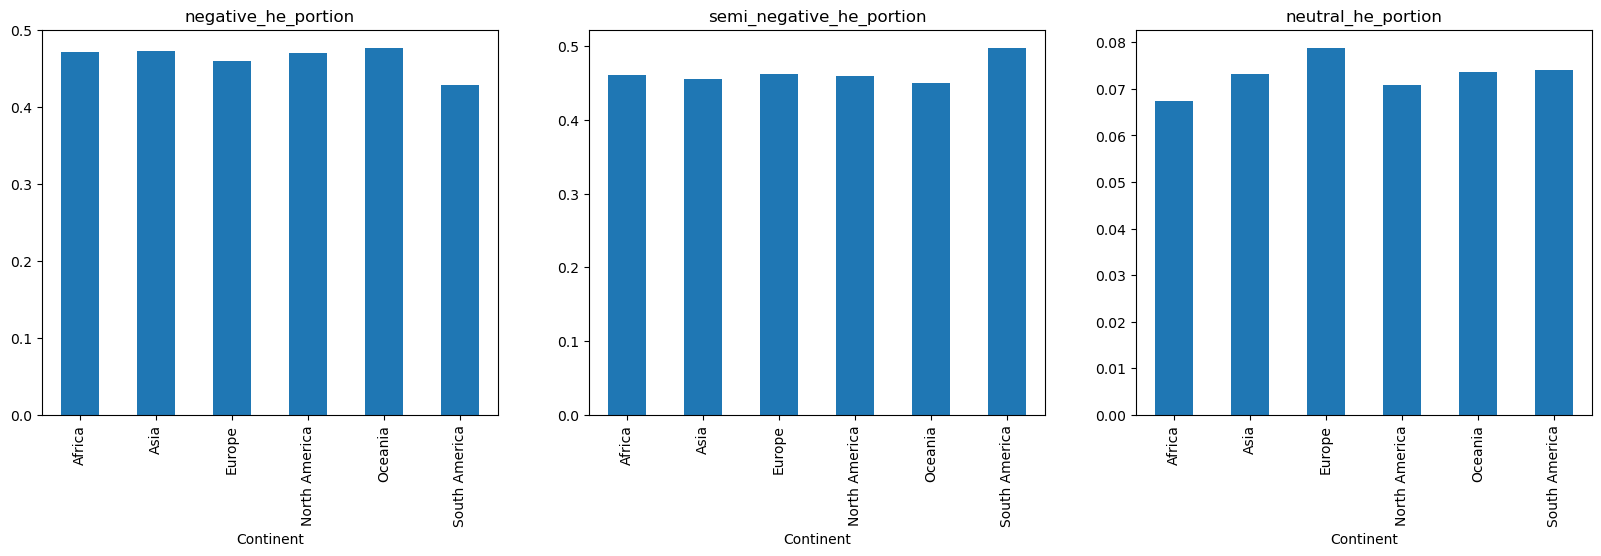

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

for i, sentiment_class in enumerate(sentiment_classes):
    analyse_df.groupby('Continent').mean()[f'{sentiment_class}_portion'].plot.bar(ax=axes[i], title=f'{sentiment_class}_portion')



### Sentiment portion vs economy (gdp per capita)

In [19]:
# https://data.worldbank.org/indicator/NY.GDP.PCAP.CD
import math

country_gdp_per_capita = pd.read_csv("data/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_4666475/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_4666475.csv").drop('Unnamed: 66', axis=1).dropna(axis=0, how='all')


country_gdp_per_capita_latest = []
no_value_indices = []

for index, row in country_gdp_per_capita.iterrows():
    gdp_values = row.values
    found = False
    for value in reversed(gdp_values):
        if not isinstance(value, float):
            break
        if not math.isnan(value):
            country_gdp_per_capita_latest.append(value)
            found = True
            break
    if not found:
        no_value_indices.append(index)
        
        

country_gdp_per_capita.drop(no_value_indices, axis=0, inplace=True)
            
country_gdp_per_capita_latest = pd.DataFrame({'Country': country_gdp_per_capita['Country Name'].values, 
                                              'Latest-GDP-per-capita': country_gdp_per_capita_latest})


country_gdp_per_capita_latest.head()


,Country,Latest-GDP-per-capita
0,Aruba,23384.298791
1,Africa Eastern and Southern,1557.722682
2,Afghanistan,516.747871
3,Africa Western and Central,1774.921218
4,Angola,2137.909393


<AxesSubplot:xlabel='Latest-GDP-per-capita', ylabel='negative_he_portion'>

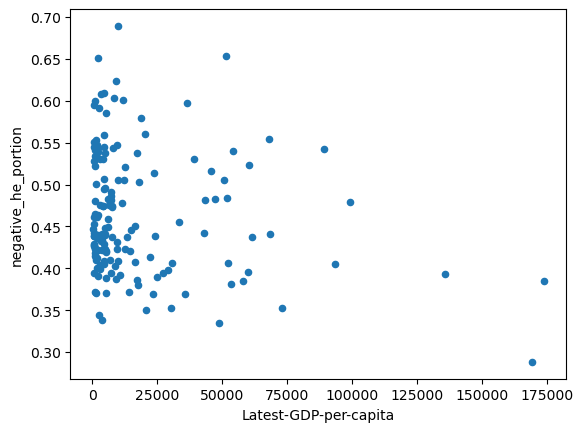

In [25]:
gdp_sentimentportion = pd.merge(country_gdp_per_capita_latest, 
         analyse_df, 
         how='inner', 
         left_on='Country', 
         right_on='country')
gdp_sentimentportion.plot.scatter(x='Latest-GDP-per-capita', y=f'negative_{pronoun_in_consideration}_portion')


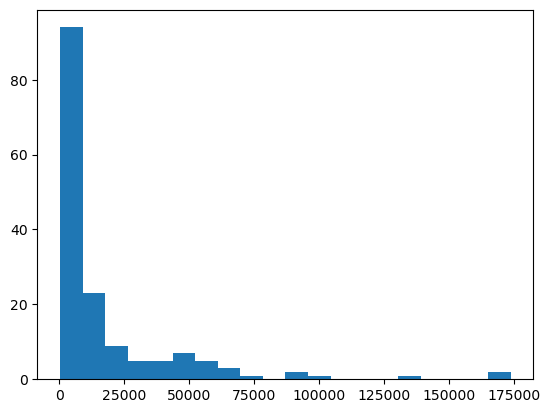

In [28]:
hist = plt.hist(gdp_sentimentportion['Latest-GDP-per-capita'], bins=20)
bin_boundaries = hist[1]

In [29]:
# Remove bins with too few samples
cut_point = 99999
for i, value in enumerate(hist[0]):
    if value < 5:
        cut_point = i
        break
        
bin_boundaries = bin_boundaries[:i]

Text(0, 0.5, 'negative_he_portion')

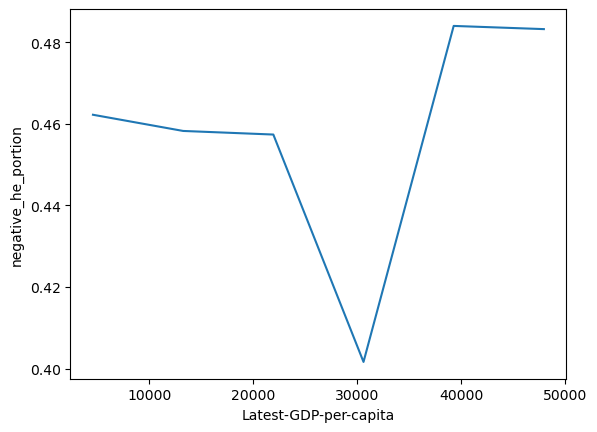

In [31]:
from scipy import stats


X = gdp_sentimentportion['Latest-GDP-per-capita']
Y = gdp_sentimentportion[f'negative_{pronoun_in_consideration}_portion']

x_plot = [(bin_boundaries[i] + bin_boundaries[i+1])/2 for i in range(0, len(bin_boundaries)-1)]
y_plot = [stats.trim_mean(Y[(bin_boundaries[i] < X) & (X < bin_boundaries[i+1])], 0.1) for i in range(0, len(bin_boundaries)-1)]
plt.plot(x_plot, y_plot)
plt.xlabel('Latest-GDP-per-capita')
plt.ylabel(f'negative_{pronoun_in_consideration}_portion')

## Correlation between he and she negative rate per country?

In [21]:
analyse_df_she = pd.read_csv("output/analyse_df_she.csv", index_col=0)
analyse_df_he = pd.read_csv("output/analyse_df_he.csv", index_col=0)

In [22]:
np.corrcoef(analyse_df_he['semi_negative_he_portion'], analyse_df_she['semi_negative_she_portion'])

array([[ 1.        , -0.26345227],
       [-0.26345227,  1.        ]])